# Deliverable 7.1: Nonlinear MPC for Landing

Implement and test a nonlinear MPC controller using CasADi for the full 12-state rocket system.

In [2]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from src.rocket import Rocket
from src.pos_rocket_vis import *
from LandMPC.nmpc_land import NmpcCtrl
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!
rocket.controller_type = 'NmpcCtrl'  # IMPORTANT: Set for proper NMPC constraint checking

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [4]:
# Landing maneuver: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
sim_time = 8  # simulation length in seconds

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities (vx, vy, vz)
               3, 2, 10])  # positions (x, y, z)

# Target state: (1, 0, 3, 0°)
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3

xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

# NMPC parameters
H = 2.0  # horizon time

# Create nonlinear MPC controller
nmpc = NmpcCtrl(rocket, Ts=Ts, H=H, xs=xs, us=us)


print("\nNonlinear MPC initialized")
print(f"  - Horizon: {nmpc.N} steps ({H}s)")
print(f"  - State dimension: {nmpc.nx}")
print(f"  - Input dimension: {nmpc.nu}")
print(f"  - Uses full nonlinear dynamics (no subsystem decomposition)")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]

Nonlinear MPC initialized
  - Horizon: 40 steps (2.0s)
  - State dimension: 12
  - Input dimension: 4
  - Uses full nonlinear dynamics (no subsystem decomposition)


## Test 1: Check Open-Loop Trajectory

Before running closed-loop, verify that the optimal open-loop trajectory from the initial state is reasonable.

Open-loop trajectory computed:
  - Initial control: [-0.2617994   0.2617994   9.9999999  -5.47894432]
  - Final state: [ 2.53619312e-03 -3.00887880e-03 -2.14317711e-01 -2.24338013e-02
  2.51732351e-02  2.80025094e-02 -1.02189623e+00 -9.17306629e-01
 -1.71382964e+00  1.01816900e+00  1.72021163e-02  4.96539921e+00]
  - Target state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]


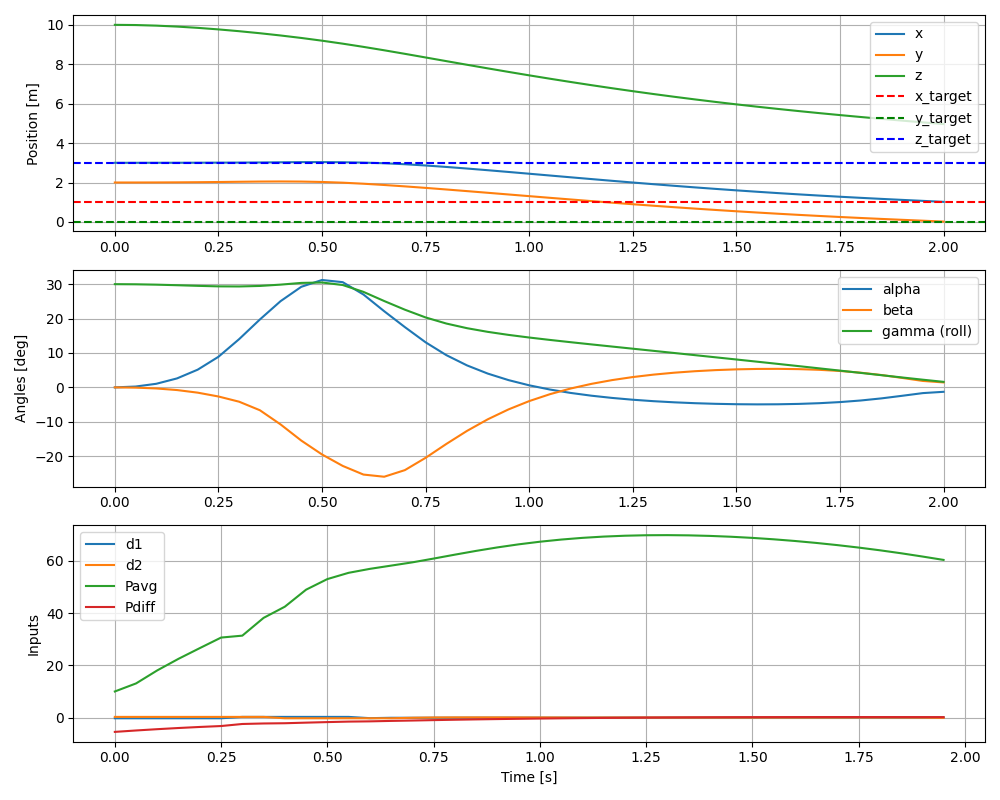

In [5]:
# Compute open-loop optimal trajectory
u0, x_ol, u_ol, t_ol = nmpc.get_u(0.0, x0, xs, us)

print("Open-loop trajectory computed:")
print(f"  - Initial control: {u0}")
print(f"  - Final state: {x_ol[:, -1]}")
print(f"  - Target state: {xs}")

# Plot open-loop trajectory
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Positions
axs[0].plot(t_ol, x_ol[9, :], label='x')
axs[0].plot(t_ol, x_ol[10, :], label='y')
axs[0].plot(t_ol, x_ol[11, :], label='z')
axs[0].axhline(y=xs[9], color='r', linestyle='--', label='x_target')
axs[0].axhline(y=xs[10], color='g', linestyle='--', label='y_target')
axs[0].axhline(y=xs[11], color='b', linestyle='--', label='z_target')
axs[0].set_ylabel('Position [m]')
axs[0].legend()
axs[0].grid(True)

# Angles
axs[1].plot(t_ol, np.rad2deg(x_ol[3, :]), label='alpha')
axs[1].plot(t_ol, np.rad2deg(x_ol[4, :]), label='beta')
axs[1].plot(t_ol, np.rad2deg(x_ol[5, :]), label='gamma (roll)')
axs[1].set_ylabel('Angles [deg]')
axs[1].legend()
axs[1].grid(True)

# Inputs
axs[2].plot(t_ol[:-1], u_ol[0, :], label='d1')
axs[2].plot(t_ol[:-1], u_ol[1, :], label='d2')
axs[2].plot(t_ol[:-1], u_ol[2, :], label='Pavg')
axs[2].plot(t_ol[:-1], u_ol[3, :], label='Pdiff')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Inputs')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()






## Test 2: Closed-Loop Simulation

In [11]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(nmpc, sim_time, H, x0, "nonlinear")



Simulating time 0.00
Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00


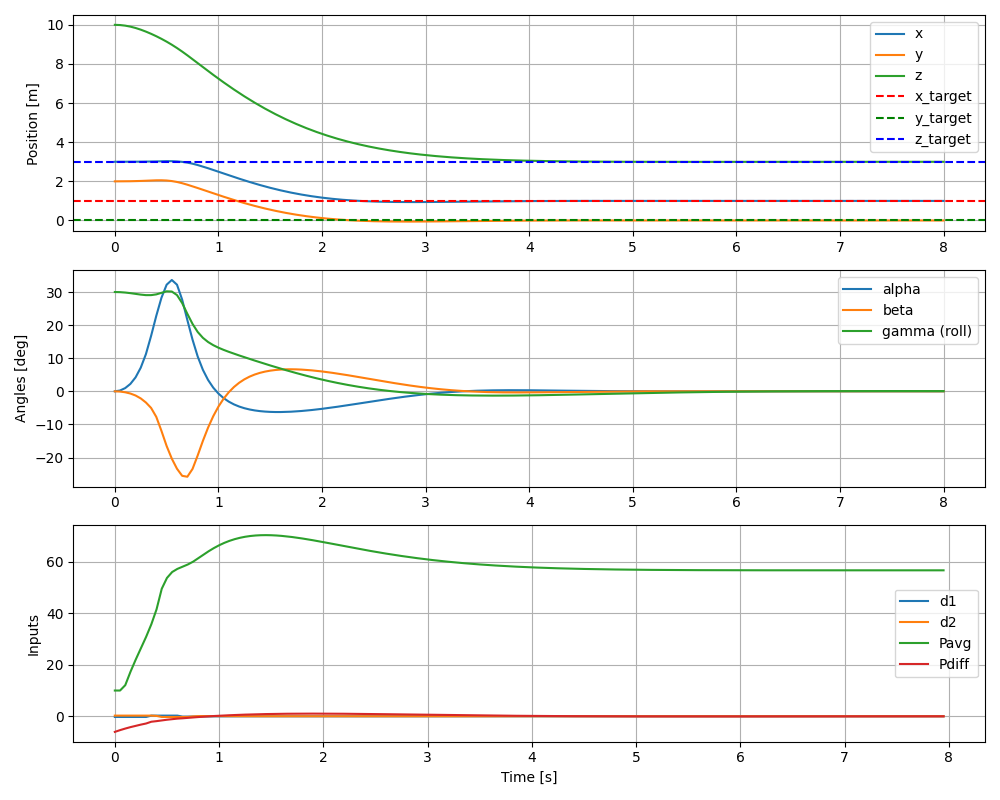

In [12]:

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Positions
axs[0].plot(t_cl, x_cl[9, :], label='x')
axs[0].plot(t_cl, x_cl[10, :], label='y')
axs[0].plot(t_cl, x_cl[11, :], label='z')
axs[0].axhline(y=xs[9], color='r', linestyle='--', label='x_target')
axs[0].axhline(y=xs[10], color='g', linestyle='--', label='y_target')
axs[0].axhline(y=xs[11], color='b', linestyle='--', label='z_target')
axs[0].set_ylabel('Position [m]')
axs[0].legend()
axs[0].grid(True)

# Angles
axs[1].plot(t_cl, np.rad2deg(x_cl[3, :]), label='alpha')
axs[1].plot(t_cl, np.rad2deg(x_cl[4, :]), label='beta')
axs[1].plot(t_cl, np.rad2deg(x_cl[5, :]), label='gamma (roll)')
axs[1].set_ylabel('Angles [deg]')
axs[1].legend()
axs[1].grid(True)

# Inputs
axs[2].plot(t_cl[:-1], u_cl[0, :], label='d1')
axs[2].plot(t_cl[:-1], u_cl[1, :], label='d2')
axs[2].plot(t_cl[:-1], u_cl[2, :], label='Pavg')
axs[2].plot(t_cl[:-1], u_cl[3, :], label='Pdiff')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Inputs')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=159, step=2), IntSlider(value=0…

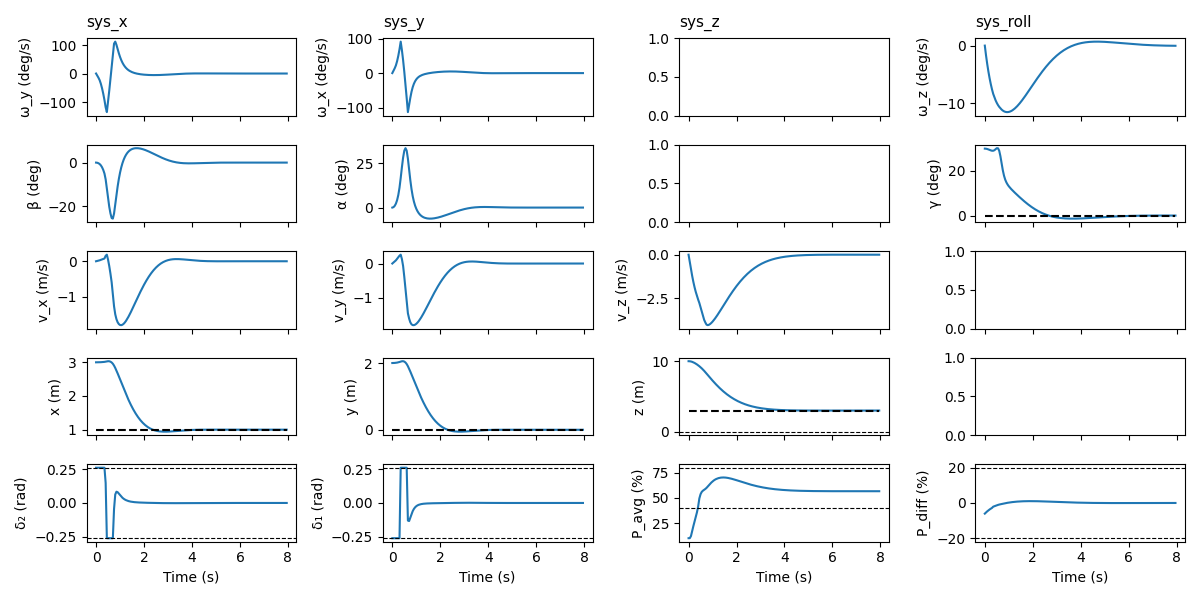

In [13]:
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)

# plot_static_states_inputs(t_cl[:80], x_cl[:,:80], u_cl[:, :80], xs)